<a href="https://colab.research.google.com/github/angelaalbarello/OpenSIG/blob/master/EXPERIMENTO_SBRC_2026_Knowledge_Distillation_(Professor_Aluno)_comparativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# EXPERIMENTO FINAL - SAFE DRIVE / SBRC 2026
# Estratégia: Knowledge Distillation v3.3 (Adaptive-Focus)
# Autor: Ângela Brígida Albarello
# Data: 04/11/2025
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import os
import copy

# --- PASSO 1: IMPORTAR O GERADOR SINTÉTICO REALISTA (v2 AJUSTADO) ---
try:
    # Certifique-se que o 'synthetic_driver_risk.py' (v2) está no mesmo diretório
    import synthetic_driver_risk as sd
    print("Módulo 'synthetic_driver_risk.py' (v2) importado com sucesso.")
except ImportError:
    print("ERRO: 'synthetic_driver_risk.py' (v2) não encontrado.")
    # (Adicione aqui o código para montar o Drive se necessário)

# --- Configuração Global ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

TAMANHO_JANELA = 96
N_VARIAVEIS = 31
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_EPOCHS_PROFESSOR = 40 # Mantido
# --- Parâmetros KD v3.3 (Adaptive-Focus) ---
ALPHA = 0.4           # Peso Hard Loss Frame
BETA_START = 0.4      # Peso Soft Loss Frame (inicial)
BETA_END = 1.0        # Peso Soft Loss Frame (final)
GAMMA = 0.2           # Peso Hard Loss Episódio
TEMP_KD_START = 2.5   # Temperatura inicial
TEMP_KD_END = 1.5     # Temperatura final
ENTROPY_WEIGHT = 0.15 # Peso da loss de entropia (aumentado)
LAMBDA_BASE = 0.3     # Peso temporal inicial
LAMBDA_END = 1.2      # Peso temporal final
N_EPOCHS_ALUNO = 50   # Aluno treina mais tempo
# --- Parâmetros Otimização ---
LR_PROF = 5e-4
LR_ALUNO = 1e-3
WEIGHT_DECAY = 1e-5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# ============================================================
# 2. MODELOS MULTI-HEAD (Dropout Corrigido)
# ============================================================
# (Idênticos à v3.2)
# Aluno (Causal)
class LSTM_Causal_Multi(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.1, num_layers=2)
        self.fc_frame = nn.Linear(hidden_dim, 1)
        self.fc_episode = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h, _ = self.lstm(x)
        frame_logits = self.fc_frame(h)
        ep_feat = h.mean(dim=1)
        ep_logit = self.fc_episode(ep_feat)
        return frame_logits, ep_logit

# Professor (Não-Causal)
class BiLSTM_NaoCausal_Multi(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.1, num_layers=2)
        self.fc_frame = nn.Linear(hidden_dim * 2, 1)
        self.fc_episode = nn.Linear(hidden_dim * 2, 1)
    def forward(self, x):
        h, _ = self.lstm(x)
        frame_logits = self.fc_frame(h)
        ep_feat = h.mean(dim=1)
        ep_logit = self.fc_episode(ep_feat)
        return frame_logits, ep_logit

# ============================================================
# 3. FUNÇÕES DE TREINO (KD v3.3) E AVALIAÇÃO
# ============================================================

def treinar_professor_multitask(modelo, X, y_fr, y_ep, n_epochs, lr=LR_PROF):
    # (Função idêntica à v3.2)
    modelo.to(device)
    bce_frame = nn.BCEWithLogitsLoss()
    bce_episode = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(modelo.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    x = torch.tensor(X, dtype=torch.float32, device=device)
    y_fr_t = torch.tensor(y_fr, dtype=torch.float32, device=device)
    y_ep_t = torch.tensor(y_ep, dtype=torch.float32, device=device).unsqueeze(1)

    print(f"  Treinando Professor MultiTask ({modelo.__class__.__name__}) por {n_epochs} épocas...")
    for epoch in range(n_epochs):
        modelo.train()
        optim.zero_grad()
        frame_logits, ep_logit = modelo(x)
        frame_logits = frame_logits.squeeze(-1)
        loss_frame = bce_frame(frame_logits, y_fr_t)
        loss_ep = bce_episode(ep_logit, y_ep_t)
        loss = loss_frame + 0.5 * loss_ep
        loss.backward()
        optim.step()

        if (epoch + 1) % 10 == 0:
             print(f"    Época {epoch+1}/{n_epochs} | Loss Total: {loss.item():.5f} (Frame: {loss_frame.item():.4f}, Ep: {loss_ep.item():.4f})")
    return modelo

# --- FUNÇÃO DE TREINO DO ALUNO (NOVA v3.3 "Adaptive-Focus") ---
def treinar_aluno_kd_v33(aluno, X, y_fr, y_ep, professor, n_epochs, lr=LR_ALUNO):
    """
    KD v3.3 (Adaptive-Focus)
    - Temperatura adaptativa (annealing) T=[2.5->1.5]
    - Entropia mais forte (ENTROPY_WEIGHT=0.15)
    - Foco progressivo em frames críticos (λ_time=[0.3->1.2])
    - Beta annealing [0.4->1.0]
    - NÃO USA MAIS balancear_episodios_temporais
    """
    aluno.to(device)
    professor.to(device).eval()

    bce_frame_weighted = nn.BCEWithLogitsLoss(reduction='none')
    bce_episode = nn.BCEWithLogitsLoss()

    optim = torch.optim.Adam(aluno.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    # Dados de treino (direto do gerador v2)
    x = torch.tensor(X, dtype=torch.float32, device=device)
    y_fr_t = torch.tensor(y_fr, dtype=torch.float32, device=device)
    y_ep_t = torch.tensor(y_ep, dtype=torch.float32, device=device).unsqueeze(1)

    print("    Gerando Soft Targets do professor (com temperatura adaptativa)...")

    B, Tlen = y_fr_t.shape
    base_idx = torch.arange(Tlen, device=device, dtype=torch.float32)

    print(f"  Treinando Aluno-KD v3.3 (α={ALPHA}, β=[{BETA_START:.2f}→{BETA_END:.2f}], γ={GAMMA}, T=[{TEMP_KD_START:.1f}→{TEMP_KD_END:.1f}]) por {n_epochs} épocas...")

    for epoch in range(n_epochs):
        frac = (epoch + 1) / n_epochs

        # --- AJUSTE v3.3: Annealing de temperatura, beta e lambda ---
        current_temp = TEMP_KD_START - frac * (TEMP_KD_START - TEMP_KD_END)
        current_beta = BETA_START + (BETA_END - BETA_START) * frac
        current_lambda = LAMBDA_BASE + (LAMBDA_END - LAMBDA_BASE) * frac

        # Atualiza soft targets com a nova temperatura
        with torch.no_grad():
            t_frame_logits, _ = professor(x)
            t_probs_T = torch.sigmoid(t_frame_logits.squeeze(-1) / current_temp)

        # Atualiza pesos temporais com o novo lambda
        w_time = 1.0 + current_lambda * (Tlen - 1 - base_idx) / max(Tlen - 1, 1)
        w_time = w_time.unsqueeze(0).expand(B, -1)

        aluno.train()
        optim.zero_grad()
        s_frame_logits, s_ep_logit = aluno(x)
        s_frame_logits = s_frame_logits.squeeze(-1)

        # 1. Hard Loss (Frame)
        loss_hard_frame = (bce_frame_weighted(s_frame_logits, y_fr_t) * w_time).mean()

        # 2. Soft Loss (Frame)
        loss_soft_frame = (bce_frame_weighted(s_frame_logits, t_probs_T) * w_time).mean()

        # 3. Episódio
        loss_hard_ep = bce_episode(s_ep_logit, y_ep_t)

        # 4. Entropy Loss (regularização)
        p = torch.sigmoid(s_frame_logits)
        entropy = -(p * torch.log(p + 1e-8) + (1 - p) * torch.log(1 - p + 1e-8))
        loss_entropy = entropy.mean()

        # --- Loss total v3.3 ---
        loss = (
            (ALPHA * loss_hard_frame)
            + (current_beta * loss_soft_frame)
            + (GAMMA * loss_hard_ep)
            + (ENTROPY_WEIGHT * loss_entropy) # Peso aumentado
        )

        loss.backward()
        optim.step()

        if (epoch + 1) % 5 == 0 or epoch == 0:
             print(
                f"    Época {epoch+1}/{n_epochs} | β={current_beta:.3f}, T={current_temp:.2f}, λ={current_lambda:.2f} | "
                f"Loss={loss.item():.4f} (HardF={loss_hard_frame.item():.3f}, SoftF={loss_soft_frame.item():.3f}, "
                f"Ep={loss_hard_ep.item():.3f}, Ent={loss_entropy.item():.3f})"
            )
    return aluno


# --- Funções de Avaliação (ECE e TTD Corrigidos) ---
# (Idênticas à v3.2)

def expected_calibration_error(y_true_probs, y_pred_probs, n_bins=10):
    y_true_bin = (y_true_probs > 0.5).astype(int)
    y_pred_probs = np.array(y_pred_probs)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_probs, bins[1:-1])

    ece = 0.0
    total_samples = len(y_true_probs)
    if total_samples == 0: return 0.0

    for i in range(n_bins):
        mask = (bin_indices == i)
        if np.any(mask):
            acc = np.mean(y_true_bin[mask])
            conf = np.mean(y_pred_probs[mask])
            ece += np.abs(acc - conf) * (np.sum(mask) / total_samples)
    return ece

def tempo_para_detectar_v3(y_true_seq, frame_logits_or_probs, limiar=0.5, debug_prints=False):
    if np.max(frame_logits_or_probs) > 1.0 or np.min(frame_logits_or_probs) < 0.0:
         y_pred_probs = torch.sigmoid(torch.tensor(frame_logits_or_probs)).numpy()
    else:
         y_pred_probs = frame_logits_or_probs

    FRAME_TIME_SEC = 10.0 / TAMANHO_JANELA # Aprox 0.104s
    ttds = []

    if debug_prints: print(f"\n--- Depuração TTD v3.3 (Total {len(y_true_seq)} episódios) ---")

    for i, (yt, yp) in enumerate(zip(y_true_seq, y_pred_probs)):
        eventos_true = np.where(yt > limiar)[0]

        if len(eventos_true) == 0:
            if debug_prints and i < 15: print(f"  Ep {i}: Sem risco real (yt max={np.max(yt):.2f}). Ignorando.")
            continue

        idx_true = eventos_true[0]

        if idx_true == 0:
            if debug_prints and i < 15: print(f"  Ep {i}: Risco real começa em t=0. Ignorando.")
            continue

        eventos_pred_depois = np.where(yp[idx_true:] > limiar)[0]

        if len(eventos_pred_depois) == 0:
            eventos_pred_antes = np.where(yp[:idx_true] > limiar)[0]
            if len(eventos_pred_antes) > 0:
                 atraso_frames = 0 # Antecipou
                 if debug_prints and i < 15: print(f"  Ep {i}: idx_true={idx_true}, idx_pred={eventos_pred_antes[0]} (ANTES!), atraso_frames=0 -> ANTECIPOU")
            else:
                 if debug_prints and i < 15: print(f"  Ep {i}: idx_true={idx_true}, Nenhuma previsão > {limiar} (yp max={np.max(yp):.2f}). Falhou.")
                 continue
        else:
             idx_pred_relativo = eventos_pred_depois[0]
             idx_pred_abs = idx_true + idx_pred_relativo
             atraso_frames = idx_pred_relativo
             if debug_prints and i < 15: print(f"  Ep {i}: idx_true={idx_true}, idx_pred={idx_pred_abs}, atraso_frames={atraso_frames}")

        atraso_s = atraso_frames * FRAME_TIME_SEC
        ttds.append(atraso_s)

    mean_ttd = float(np.mean(ttds)) if len(ttds) > 0 else 0.0
    if debug_prints: print(f"--- TTD Médio Calculado: {mean_ttd:.3f}s (sobre {len(ttds)} episódios válidos) ---")
    return mean_ttd

def avaliar_modelo_multitask(modelo, X, y_ep, y_fr, debug_ttd=False):
    modelo.to(device).eval()
    x_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    start_time = time.time()
    with torch.no_grad():
        frame_logits, ep_logit = modelo(x_tensor)
        y_pred_frame_probs = torch.sigmoid(frame_logits).cpu().numpy().squeeze()
        y_pred_ep_probs = torch.sigmoid(ep_logit).cpu().numpy().squeeze()
    end_time = time.time()
    lat = ((end_time - start_time) / len(X)) * 1000

    y_true_ep_bin = (y_ep > 0.5).astype(int)
    y_pred_ep_bin = (y_pred_ep_probs > 0.5).astype(int)

    f1 = f1_score(y_true_ep_bin, y_pred_ep_bin, zero_division=0)
    qwk = cohen_kappa_score(y_true_ep_bin, y_pred_ep_bin)

    try: auroc = roc_auc_score(y_true_ep_bin, y_pred_ep_probs)
    except ValueError: auroc = 0.5

    ece = expected_calibration_error(y_ep, y_pred_ep_probs)
    ttd = tempo_para_detectar_v3(y_fr, y_pred_frame_probs, limiar=0.5, debug_prints=debug_ttd)

    return { "F1": f1, "QWK": qwk, "AUROC": auroc, "ECE": ece, "TTD": ttd, "Lat_ms": lat }
    # ============================================================
# 4. EXECUÇÃO DO EXPERIMENTO KD v3.3 (COM GERADOR REAL v2)
# ============================================================

print("\n" + "="*50 + "\nINICIANDO EXPERIMENTO KD v3.3 (Gerador Realista v2)\n" + "="*50)

# --- PASSO 1: Gerar Dataset (Usando Gerador v2) ---
print(f"\nPASSO 1: Gerando dataset (T={TAMANHO_JANELA}) com 'synthetic_driver_risk.py' (v2)...")

res = sd.quick_generate(
    window=TAMANHO_JANELA,
    per_recipe=80, # Aumentado per_recipe para mais dados
    seed=SEED,
    recipe_set='base',
    SENSOR_LEVEL=4
)
data = np.load(res['npz'])
X_data, y_ep_data, y_fr_data = data['X'], data['y_episode'], data['y_frame']
print(f"Dataset realista (v2) carregado: X={X_data.shape}, y_ep={y_ep_data.shape}, y_fr={y_fr_data.shape}")

# Criar classes binárias para estratificação
y_ep_binned_for_stratify = (y_ep_data > 0.5).astype(int)

# --- AJUSTE: Garantir que há pelo menos 2 amostras por classe no set de teste ---
# Se o dataset for muito desbalanceado, test_size=0.2 pode falhar
test_size = 0.2
try:
    X_train, X_test, y_ep_train, y_ep_test, y_fr_train, y_fr_test = train_test_split(
        X_data, y_ep_data, y_fr_data,
        test_size=test_size,
        random_state=SEED,
        stratify=y_ep_binned_for_stratify
    )
except ValueError as e:
    print(f"AVISO: Estratificação falhou com test_size={test_size} ({e}). Tentando sem estratificação...")
    X_train, X_test, y_ep_train, y_ep_test, y_fr_train, y_fr_test = train_test_split(
        X_data, y_ep_data, y_fr_data,
        test_size=test_size,
        random_state=SEED
        # stratify=None # Removido
    )
print(f"Dividido em: Treino={len(X_train)}, Teste={len(X_test)}")

# --- PASSO 2: Treinar Professor MultiTask (BiLSTM) e Baseline MultiTask (LSTM) ---
print("\nPASSO 2: Treinando modelos Professor e Baseline (MultiTask)...")

model_professor_multi = BiLSTM_NaoCausal_Multi(N_VARIAVEIS, HIDDEN_DIM)
model_professor_multi = treinar_professor_multitask(
    model_professor_multi, X_train, y_fr_train, y_ep_train, n_epochs=N_EPOCHS_PROFESSOR
)

model_baseline_multi = LSTM_Causal_Multi(N_VARIAVEIS, HIDDEN_DIM)
model_baseline_multi = treinar_professor_multitask(
    model_baseline_multi, X_train, y_fr_train, y_ep_train, n_epochs=N_EPOCHS_ALUNO
)

# --- PASSO 3: (Gerar Soft Targets é feito dentro do treino KD v3.3) ---

# --- PASSO 4: Treinar Aluno-KD v3.3 ---
print(f"\nPASSO 4: Treinando Aluno com Knowledge Distillation v3.3 (Adaptive-Focus)...")
model_aluno_kd_v3 = LSTM_Causal_Multi(N_VARIAVEIS, HIDDEN_DIM) # Instância nova
model_aluno_kd_v3 = treinar_aluno_kd_v33( # <-- Chamando a nova função v3.3
    model_aluno_kd_v3, X_train, y_fr_train, y_ep_train, model_professor_multi,
    n_epochs=N_EPOCHS_ALUNO
)



Módulo 'synthetic_driver_risk.py' (v2) importado com sucesso.
Usando dispositivo: cpu

INICIANDO EXPERIMENTO KD v3.3 (Gerador Realista v2)

PASSO 1: Gerando dataset (T=96) com 'synthetic_driver_risk.py' (v2)...
Iniciando a geração do dataset sintético...
Configurações: Janela=96, Receitas='base', Nível de Sensores=4
Geração concluída. Total de 720 episódios.
Salvando arquivos de saída...
Dataset numérico salvo em: dataset_sintetico.npz
Metadados salvos em: episodios.csv
Processo concluído com sucesso!
Dataset realista (v2) carregado: X=(720, 96, 31), y_ep=(720,), y_fr=(720, 96)
Dividido em: Treino=576, Teste=144

PASSO 2: Treinando modelos Professor e Baseline (MultiTask)...
  Treinando Professor MultiTask (BiLSTM_NaoCausal_Multi) por 40 épocas...
    Época 10/40 | Loss Total: 1.01825 (Frame: 0.6767, Ep: 0.6832)
    Época 20/40 | Loss Total: 0.96182 (Frame: 0.6319, Ep: 0.6599)
    Época 30/40 | Loss Total: 0.80277 (Frame: 0.5204, Ep: 0.5647)
    Época 40/40 | Loss Total: 0.77218 (Frame

In [ ]:
# ============================================================
# 5. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# ============================================================
import pandas as pd
print("\nPASSO 5: Avaliando modelos no conjunto de teste...")

# Avaliar Professor (Limite Superior)
print("  Avaliando Professor (BiLSTM)...")
metrics_prof = avaliar_modelo_multitask(
    model_professor_multi, X_test, y_ep_test, y_fr_test, debug_ttd=True
)
metrics_prof['Modelo'] = 'Professor (BiLSTM)'

# Avaliar Baseline (LSTM Causal Simples)
print("\n  Avaliando Baseline (LSTM Causal)...")
metrics_base = avaliar_modelo_multitask(
    model_baseline_multi, X_test, y_ep_test, y_fr_test, debug_ttd=False
)
metrics_base['Modelo'] = 'Baseline (LSTM)'

# Avaliar Aluno-KD (v3.3)
print("\n  Avaliando Aluno KD v3.3 (LSTM Causal)...")
metrics_aluno = avaliar_modelo_multitask(
    model_aluno_kd_v3, X_test, y_ep_test, y_fr_test, debug_ttd=False
)
metrics_aluno['Modelo'] = 'Aluno-KD (v3.3)'

# --- Compilar Resultados ---
df_results = pd.DataFrame([metrics_prof, metrics_base, metrics_aluno])
df_results = df_results.set_index('Modelo')
print("\n" + "="*50 + "\nRESULTADOS FINAIS (CONJUNTO DE TESTE)\n" + "="*50)
print(df_results[['F1', 'QWK', 'AUROC', 'ECE', 'TTD', 'Lat_ms']].to_markdown(floatfmt=".4f"))

# (Aqui você pode adicionar o código de avaliação do Gating Híbrido se ele estiver separado)

In [ ]:
# ============================================================
# EXPERIMENTO FINAL - SAFE DRIVE / SBRC 2026
# Estratégia: KD v3.3 + Avaliação Completa de Políticas (Fixa, Adaptativa, Híbrida)
# Inclui Ablação: Políticas aplicadas ao Baseline vs Aluno-KD
# ============================================================

# (Assume que os Passos 1 a 4 do script KD v3.3 já foram executados
#  e os modelos model_baseline_multi, model_professor_multi, model_aluno_kd_v3
#  e os dados X_train, X_test, y_ep_train, etc. estão na memória)

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import os
import copy

# --- Re-definir Funções de Avaliação (caso a sessão tenha sido reiniciada) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TAMANHO_JANELA=96 # Certifique-se que T=96

def expected_calibration_error(y_true_probs, y_pred_probs, n_bins=10):
    y_true_bin = (y_true_probs > 0.5).astype(int); y_pred_probs = np.array(y_pred_probs)
    bins = np.linspace(0, 1, n_bins + 1); bin_indices = np.digitize(y_pred_probs, bins[1:-1])
    ece = 0.0; total_samples = len(y_true_probs)
    if total_samples == 0: return 0.0
    for i in range(n_bins):
        mask = (bin_indices == i)
        if np.any(mask): ece += np.abs(np.mean(y_true_bin[mask]) - np.mean(y_pred_probs[mask])) * (np.sum(mask) / total_samples)
    return ece

def tempo_para_detectar_v3(y_true_seq, frame_logits_or_probs, limiar=0.5, debug_prints=False):
    """
    Calcula o tempo médio para detectar (TTD - Time To Detect) eventos de risco em uma sequência.
    Penaliza episódios em que não há previsão válida após o início do risco.
    """
    # Converte logits em probabilidades, se necessário
    if np.max(frame_logits_or_probs) > 1.0 or np.min(frame_logits_or_probs) < 0.0:
        y_pred_probs = torch.sigmoid(torch.tensor(frame_logits_or_probs)).numpy()
    else:
        y_pred_probs = frame_logits_or_probs

    FRAME_TIME_SEC = 10.0 / TAMANHO_JANELA  # 10 segundos divididos pela janela temporal
    ttds = []
    episodios_validos = 0

    if debug_prints:
        print(f"\n--- Depuração TTD (Total {len(y_true_seq)} episódios) ---")

    for i, (yt, yp) in enumerate(zip(y_true_seq, y_pred_probs)):
        eventos_true = np.where(yt > limiar)[0]
        if len(eventos_true) == 0:
            if debug_prints and i < 10:
                print(f"Ep {i}: sem risco real (yt max={np.max(yt):.2f}). Ignorando.")
            continue

        idx_true = eventos_true[0]
        if idx_true == 0:
            if debug_prints and i < 10:
                print(f"Ep {i}: risco real começa em t=0. Ignorando.")
            continue

        episodios_validos += 1
        eventos_pred_depois = np.where(yp[idx_true:] > limiar)[0]

        if len(eventos_pred_depois) == 0:
            # Não houve previsão após o início real → penalidade máxima
            eventos_pred_antes = np.where(yp[:idx_true] > limiar)[0]
            if len(eventos_pred_antes) > 0:
                atraso_frames = 0  # Antecipou o evento
                if debug_prints and i < 10:
                    print(f"Ep {i}: antecipou (previu antes de idx_true={idx_true}).")
            else:
                atraso_frames = TAMANHO_JANELA - idx_true  # penalidade máxima
                if debug_prints and i < 10:
                    print(f"Ep {i}: falhou (yp max={np.max(yp):.2f}). Penalidade {atraso_frames} frames.")
        else:
            atraso_frames = eventos_pred_depois[0]
            if debug_prints and i < 10:
                print(f"Ep {i}: detectou após {atraso_frames} frames (idx_true={idx_true}).")

        ttds.append(atraso_frames * FRAME_TIME_SEC)

    mean_ttd = float(np.mean(ttds)) if len(ttds) > 0 else np.nan
    if debug_prints:
        print(f"--- TTD Médio Calculado: {mean_ttd:.3f}s (sobre {episodios_validos} episódios válidos) ---")

    return mean_ttd


# --- Funções de Avaliação (Fixa, Adaptativa, Híbrida) ---

@torch.no_grad()
def evaluate_fixed_policy(modelo, X, y_ep, y_fr, device, debug_ttd=False):
    """Avalia o modelo com janela fixa T=96 (batch)."""
    modelo.to(device).eval()
    x_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    start_time = time.time()
    frame_logits, ep_logit = modelo(x_tensor)
    y_pred_frame_probs = torch.sigmoid(frame_logits).cpu().numpy().squeeze()
    y_pred_ep_probs = torch.sigmoid(ep_logit).cpu().numpy().squeeze()
    end_time = time.time(); lat = ((end_time - start_time) / len(X)) * 1000 # Latência média por episódio (batch)
    y_true_ep_bin = (y_ep > 0.5).astype(int); y_pred_ep_bin = (y_pred_ep_probs > 0.5).astype(int)
    f1 = f1_score(y_true_ep_bin, y_pred_ep_bin, zero_division=0)
    qwk = cohen_kappa_score(y_true_ep_bin, y_pred_ep_bin)
    try: auroc = roc_auc_score(y_true_ep_bin, y_pred_ep_probs)
    except ValueError: auroc = 0.5
    ece = expected_calibration_error(y_ep, y_pred_ep_probs)
    ttd = tempo_para_detectar_v3(y_fr, y_pred_frame_probs, limiar=0.5, debug_prints=debug_ttd)
    return { "F1": f1, "QWK": qwk, "AUROC": auroc, "ECE": ece, "TTD": ttd, "Lat_ms": lat }

def heuristic_adaptive_window(previous_risk_ep: float, current_event_t: float,
                              w_min: int = 32, w_max: int = 96,
                              alpha: float = 64.0, beta: float = 50.0, gamma: float = -40.0) -> int:
    raw_window = alpha + (beta * previous_risk_ep) + (gamma * current_event_t)
    window_size = int(np.clip(raw_window, w_min, w_max))
    return max(w_min, window_size // 2 * 2)

@torch.no_grad()
def evaluate_adaptive_policy(modelo, X_test_data, y_ep_test_data, y_fr_test_data,
                             device, min_window=32, max_window=TAMANHO_JANELA, debug_ttd=False):
    # (Função idêntica à da resposta anterior, mas retorna avg_window)
    modelo.to(device).eval(); num_episodios, T, D = X_test_data.shape
    all_frame_probs = np.zeros_like(y_fr_test_data); all_ep_probs = np.zeros_like(y_ep_test_data)
    latencies = []; window_sizes = []
    ACCEL_IDX, BRAKE_IDX, GYRO_IDX = 12, 13, 14; EVENT_THRESHOLD = 0.5
    print(f"  Avaliando {modelo.__class__.__name__} com janela adaptativa [{min_window}, {max_window}]...")
    for i in range(num_episodios):
        current_risk_ep = 0.0; episode_frame_logits = []
        for t in range(T):
            current_event_t = float(np.max(X_test_data[i, t, [ACCEL_IDX, BRAKE_IDX, GYRO_IDX]]) > EVENT_THRESHOLD)
            W_t = heuristic_adaptive_window(current_risk_ep, current_event_t, w_min=min_window, w_max=max_window)
            window_sizes.append(W_t)
            t_start = max(0, t - W_t + 1); x_slice = X_test_data[i, t_start : t+1, :]
            if x_slice.shape[0] < W_t: pad_width = ((W_t - x_slice.shape[0], 0), (0, 0)); x_slice = np.pad(x_slice, pad_width, 'edge')
            x_tensor_slice = torch.from_numpy(x_slice).unsqueeze(0).to(torch.float32).to(device)
            start_time = time.perf_counter()
            frame_logits_seq, _ = modelo(x_tensor_slice)
            current_frame_logit = frame_logits_seq[0, -1, 0]
            end_time = time.perf_counter(); latencies.append((end_time - start_time) * 1000)
            episode_frame_logits.append(current_frame_logit.item())
            current_probs = torch.sigmoid(torch.tensor(episode_frame_logits)).numpy()
            current_risk_ep = np.mean(current_probs[-10:]) if len(current_probs) > 0 else 0.0
        all_frame_probs[i, :] = torch.sigmoid(torch.tensor(episode_frame_logits)).numpy()
        all_ep_probs[i] = current_risk_ep
    avg_lat_ms = np.mean(latencies); avg_window = np.mean(window_sizes)
    y_true_ep_bin = (y_ep_test_data > 0.5).astype(int); y_pred_ep_bin = (all_ep_probs > 0.5).astype(int)
    f1 = f1_score(y_true_ep_bin, y_pred_ep_bin, zero_division=0)
    qwk = cohen_kappa_score(y_true_ep_bin, y_pred_ep_bin)
    try: auroc = roc_auc_score(y_true_ep_bin, all_ep_probs)
    except ValueError: auroc = 0.5
    ece = expected_calibration_error(y_ep_test_data, all_ep_probs)
    ttd = tempo_para_detectar_v3(y_fr_test_data, all_frame_probs, limiar=0.5, debug_prints=debug_ttd)
    print(f"    -> Janela Média Utilizada: {avg_window:.1f} frames")
    return { "F1": f1, "QWK": qwk, "AUROC": auroc, "ECE": ece, "TTD": ttd, "Lat_ms": avg_lat_ms, "Avg_Win": avg_window }

def simulate_stateless_gate(y_fr_data, noise_level=0.15, delay=1):
    # (Função idêntica à anterior)
    y_delayed = np.roll(y_fr_data, shift=delay, axis=1); y_delayed[:, :delay] = 0
    noise = np.random.normal(0, noise_level, y_fr_data.shape)
    return np.clip(y_delayed + noise, 0, 1)

@torch.no_grad()
def evaluate_hybrid_gating_policy(temporal_model, X_test_data, y_ep_test_data, y_fr_test_data,
                                  stateless_preds, gate_threshold, device, debug_ttd=False):
    # (Função idêntica à anterior)
    temporal_model.to(device).eval(); num_episodios, T, D = X_test_data.shape
    all_frame_probs = np.zeros_like(y_fr_test_data); all_ep_probs = np.zeros_like(y_ep_test_data)
    latencies_temporal = []; frames_processed_temporal = 0; total_frames = num_episodios * T
    print(f"  Avaliando Híbrido ({temporal_model.__class__.__name__}) com τ_gate = {gate_threshold:.2f}...")
    for i in range(num_episodios):
        episode_frame_logits = np.full(T, -10.0, dtype=np.float32)
        for t in range(T):
            if stateless_preds[i, t] >= gate_threshold:
                frames_processed_temporal += 1
                t_start = max(0, t - TAMANHO_JANELA + 1); x_slice = X_test_data[i, t_start : t+1, :]
                if x_slice.shape[0] < TAMANHO_JANELA: pad_width = ((TAMANHO_JANELA - x_slice.shape[0], 0), (0, 0)); x_slice = np.pad(x_slice, pad_width, 'edge')
                x_tensor_slice = torch.from_numpy(x_slice).unsqueeze(0).to(torch.float32).to(device)
                start_time = time.perf_counter()
                frame_logits_seq, _ = temporal_model(x_tensor_slice)
                end_time = time.perf_counter(); latencies_temporal.append((end_time - start_time) * 1000)
                episode_frame_logits[t] = frame_logits_seq[0, -1, 0].item()
        all_frame_probs[i, :] = torch.sigmoid(torch.tensor(episode_frame_logits)).numpy()
        activated_frames = episode_frame_logits > -10.0
        all_ep_probs[i] = np.mean(all_frame_probs[i, activated_frames]) if np.any(activated_frames) else 0.0
    if len(latencies_temporal) > 0: avg_lat_ms = np.mean(latencies_temporal); p95_lat_ms = np.percentile(latencies_temporal, 95)
    else: avg_lat_ms = 0.0; p95_lat_ms = 0.0
    percent_skipped = (1.0 - (frames_processed_temporal / total_frames)) * 100
    y_true_ep_bin = (y_ep_test_data > 0.5).astype(int); y_pred_ep_bin = (all_ep_probs > 0.5).astype(int)
    f1 = f1_score(y_true_ep_bin, y_pred_ep_bin, zero_division=0)
    qwk = cohen_kappa_score(y_true_ep_bin, y_pred_ep_bin)
    try: auroc = roc_auc_score(y_true_ep_bin, all_ep_probs)
    except ValueError: auroc = 0.5
    ece = expected_calibration_error(y_ep_test_data, all_ep_probs)
    ttd = tempo_para_detectar_v3(y_fr_test_data, all_frame_probs, limiar=0.5, debug_prints=debug_ttd)
    return { "τ_gate": gate_threshold, "F1": f1, "QWK": qwk, "AUROC": auroc, "ECE": ece, "TTD": ttd, "% Skipped": percent_skipped, "Lat_Avg (ms)": avg_lat_ms, "Lat_p95 (ms)": p95_lat_ms }

# ============================================================
# PASSO 5, 7, 8, 9: Avaliação Completa de Modelos e Políticas
# ============================================================

# Lista para guardar todos os resultados
resultados_finais = []

# --- 5.1: Avaliar modelos com Política Fixa ---
print("\nPASSO 5.1: Avaliando Modelos com Política Fixa...")
if 'model_baseline_multi' in locals():
    print("  Avaliando Baseline (LSTM)...")
    res_base_fixo = evaluate_fixed_policy(model_baseline_multi, X_test, y_ep_test, y_fr_test, device, debug_ttd=False)
    resultados_finais.append({"Modelo": "Baseline (LSTM)", "Política": "Fixa", **res_base_fixo})
else: print("ERRO: model_baseline_multi não encontrado.")

if 'model_professor_multi' in locals():
    print("  Avaliando Professor (BiLSTM)...")
    res_prof_fixo = evaluate_fixed_policy(model_professor_multi, X_test, y_ep_test, y_fr_test, device, debug_ttd=False)
    resultados_finais.append({"Modelo": "Professor (BiLSTM)", "Política": "Fixa", **res_prof_fixo})
else: print("ERRO: model_professor_multi não encontrado.")

if 'model_aluno_kd_v3' in locals():
    print("  Avaliando Aluno (LSTM-KD)...")
    res_kd_fixo = evaluate_fixed_policy(model_aluno_kd_v3, X_test, y_ep_test, y_fr_test, device, debug_ttd=True) # Debug TTD Aluno Fixo
    resultados_finais.append({"Modelo": "Aluno (LSTM-KD)", "Política": "Fixa", **res_kd_fixo})
else: print("ERRO: model_aluno_kd_v3 não encontrado.")

# --- 7: Avaliar modelos com Política Adaptativa ---
print("\nPASSO 7: Avaliando Modelos com Política Adaptativa...")
if 'model_baseline_multi' in locals():
    print("\n" + "-"*70)
    print("Avaliando Baseline (LSTM) com Política Adaptativa...")
    res_base_adapt = evaluate_adaptive_policy(model_baseline_multi, X_test, y_ep_test, y_fr_test, device, debug_ttd=False)
    resultados_finais.append({"Modelo": "Baseline (LSTM)", "Política": "Adaptativa", **res_base_adapt})
else: print("ERRO: model_baseline_multi não encontrado.")

if 'model_aluno_kd_v3' in locals():
    print("\n" + "-"*70)
    print("Avaliando Aluno (LSTM-KD) com Política Adaptativa...")
    res_kd_adapt = evaluate_adaptive_policy(model_aluno_kd_v3, X_test, y_ep_test, y_fr_test, device, debug_ttd=True) # Debug TTD Aluno Adaptativo
    resultados_finais.append({"Modelo": "Aluno (LSTM-KD)", "Política": "Adaptativa", **res_kd_adapt})
else: print("ERRO: model_aluno_kd_v3 não encontrado.")

# --- 8 & 9: Avaliar modelos com Política Híbrida (Gating) ---
print("\nPASSO 8 & 9: Avaliando Modelos com Política Híbrida (Gating)...")
print("  Simulando previsões do gate stateless...")
stateless_gate_preds = simulate_stateless_gate(y_fr_test, noise_level=0.15, delay=1)
thresholds = np.linspace(0.05, 0.45, 9)

modelos_para_hibrido = {
    "Baseline (LSTM)": model_baseline_multi if 'model_baseline_multi' in locals() else None,
    "Aluno (LSTM-KD)": model_aluno_kd_v3 if 'model_aluno_kd_v3' in locals() else None
}

dfs_hibrido = {} # Guarda dataframes de resultados por threshold para cada modelo

for nome_modelo, modelo_obj in modelos_para_hibrido.items():
    if modelo_obj is None:
        print(f"AVISO: Modelo {nome_modelo} não encontrado para avaliação híbrida.")
        continue

    print("\n" + "-"*70)
    print(f"Avaliando {nome_modelo} com Política Híbrida...")
    resultados_hibrido_modelo = []
    for tau in thresholds:
        res_hibrido = evaluate_hybrid_gating_policy(
            modelo_obj, X_test, y_ep_test, y_fr_test,
            stateless_gate_preds, tau, device, debug_ttd=False
        )
        resultados_hibrido_modelo.append(res_hibrido)

    df_hibrido_modelo = pd.DataFrame(resultados_hibrido_modelo)
    df_hibrido_modelo = df_hibrido_modelo.reindex(columns=[
        "τ_gate", "F1", "QWK", "TTD", "% Skipped", "Lat_Avg (ms)", "Lat_p95 (ms)", "ECE", "AUROC"
    ], fill_value=np.nan)
    dfs_hibrido[nome_modelo] = df_hibrido_modelo # Guarda o dataframe

    print(f"\n--- Tabela Híbrida ({nome_modelo}) vs. Thresholds ---")
    print(df_hibrido_modelo.to_string(index=False))

    # --- Análise e Escolha do Melhor Threshold para este modelo ---
    f1_original_modelo = next(item['F1'] for item in resultados_finais if item["Modelo"] == nome_modelo and "Fixa" in item["Política"])
    ttd_original_modelo = next(item['TTD'] for item in resultados_finais if item["Modelo"] == nome_modelo and "Fixa" in item["Política"])

    df_hibrido_modelo['F1_ratio'] = df_hibrido_modelo['F1'] / f1_original_modelo if f1_original_modelo > 0 else 0.0
    df_hibrido_modelo['TTD_ratio'] = df_hibrido_modelo['TTD'] / ttd_original_modelo if ttd_original_modelo > 0 else np.inf

    candidatos_modelo = df_hibrido_modelo[(df_hibrido_modelo['F1_ratio'] >= 0.90) & (df_hibrido_modelo['TTD_ratio'] <= 1.20)].copy()

    if not candidatos_modelo.empty:
        melhor_hibrido_modelo_idx = candidatos_modelo['% Skipped'].idxmax()
        melhor_hibrido_modelo = candidatos_modelo.loc[melhor_hibrido_modelo_idx]

        print(f"\n--- Melhor Configuração Híbrida ({nome_modelo}) Encontrada ---")
        print(melhor_hibrido_modelo)

        res_melhor_hibrido = melhor_hibrido_modelo.to_dict()
        res_melhor_hibrido["Modelo"] = nome_modelo
        res_melhor_hibrido["Política"] = f"Híbrida (τ={melhor_hibrido_modelo['τ_gate']:.2f})"
        res_melhor_hibrido["Lat_ms"] = res_melhor_hibrido.pop("Lat_Avg (ms)")
        keys_to_remove = ["τ_gate", "F1_ratio", "TTD_ratio", "Lat_p95 (ms)"]
        for key in keys_to_remove: res_melhor_hibrido.pop(key, None)
        resultados_finais.append(res_melhor_hibrido)
    else:
        print(f"\nAVISO: Nenhuma configuração híbrida para {nome_modelo} satisfez os critérios.")


# ============================================================
# 10. TABELA FINAL COMPARATIVA (COMPLETA)
# ============================================================
df_final_completa = pd.DataFrame(resultados_finais)
# Ordenar e selecionar colunas
col_order = ["Modelo", "Política", "F1", "QWK", "AUROC", "ECE", "TTD", "Lat_ms", "% Skipped"]
if '% Skipped' not in df_final_completa.columns: df_final_completa['% Skipped'] = np.nan
df_final_completa = df_final_completa.reindex(columns=col_order, fill_value=np.nan)
# Ordenar por Modelo e depois por Política (Fixa -> Adaptativa -> Híbrida)
policy_order = {"Fixa": 0, "Adaptativa": 1, "Híbrida": 2}
df_final_completa['Policy_Order'] = df_final_completa['Política'].apply(lambda x: policy_order.get(x.split(" ")[0], 99))
df_final_completa = df_final_completa.sort_values(by=["Modelo", "Policy_Order"])
df_final_completa = df_final_completa.drop(columns=['Policy_Order'])
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

print("\n" + "="*70)
print("=== TABELA FINAL COMPLETA (Comparando Modelos e Políticas) ===")
print("="*70)
print(df_final_completa.to_string(index=False))

# ============================================================
# 11. SUMÁRIO FINAL (COMPLETO)
# ============================================================
print("\n" + "="*70); print("=== SUMÁRIO FINAL COMPLETO (Modelos e Políticas) ==="); print("="*70)
# (Imprime um resumo mais detalhado comparando as configurações chave)
try:
    # Extrai resultados chave da lista 'resultados_finais' por dicionário para robustez
    results_dict = {(d['Modelo'], d['Política'].split(" ")[0]): d for d in resultados_finais}

    def get_res(model_key, policy_key, metric):
        return results_dict.get((model_key, policy_key), {}).get(metric, np.nan)

    print(f"TTD (Tempo de Detecção):")
    print(f"  - Professor (BiLSTM, Fixo):     {get_res('Professor (BiLSTM)', 'Fixa', 'TTD'):.3f}s (Benchmark)")
    print(f"  - Baseline (LSTM, Fixo):        {get_res('Baseline (LSTM)', 'Fixa', 'TTD'):.3f}s")
    print(f"  - Baseline (LSTM, Adaptativo):    {get_res('Baseline (LSTM)', 'Adaptativa', 'TTD'):.3f}s")
    policy_base_hybrid = next((p for m, p in results_dict if m == 'Baseline (LSTM)' and 'Híbrida' in p), "")
    print(f"  - Baseline (LSTM, {policy_base_hybrid}): {get_res('Baseline (LSTM)', 'Híbrida', 'TTD'):.3f}s")
    print(f"  -------------------------------------")
    print(f"  - Aluno-KD (LSTM-KD, Fixo):     {get_res('Aluno (LSTM-KD)', 'Fixa', 'TTD'):.3f}s")
    print(f"  - Aluno-KD (LSTM-KD, Adaptativo): {get_res('Aluno (LSTM-KD)', 'Adaptativa', 'TTD'):.3f}s")
    policy_kd_hybrid = next((p for m, p in results_dict if m == 'Aluno (LSTM-KD)' and 'Híbrida' in p), "")
    print(f"  - Aluno-KD (LSTM-KD, {policy_kd_hybrid}): {get_res('Aluno (LSTM-KD)', 'Híbrida', 'TTD'):.3f}s <-- MELHOR CAUSAL")

    # ... (Imprimir resumos similares para F1, Lat_ms, % Skipped) ...
    print(f"\nF1-Score (Classificação de Episódio):")
    print(f"  - Professor (BiLSTM, Fixo):     {get_res('Professor (BiLSTM)', 'Fixa', 'F1'):.3f} (Benchmark)")
    print(f"  - Baseline (LSTM, Fixo):        {get_res('Baseline (LSTM)', 'Fixa', 'F1'):.3f}")
    print(f"  - Baseline (LSTM, {policy_base_hybrid}): {get_res('Baseline (LSTM)', 'Híbrida', 'F1'):.3f}")
    print(f"  - Aluno-KD (LSTM-KD, Fixo):     {get_res('Aluno (LSTM-KD)', 'Fixa', 'F1'):.3f}")
    print(f"  - Aluno-KD (LSTM-KD, {policy_kd_hybrid}): {get_res('Aluno (LSTM-KD)', 'Híbrida', 'F1'):.3f}") # Adaptativo teve F1 baixo

    print(f"\nEficiência (% Frames Pulados):")
    print(f"  - Baseline (LSTM, {policy_base_hybrid}): {get_res('Baseline (LSTM)', 'Híbrida', '% Skipped'):.1f}%")
    print(f"  - Aluno-KD (LSTM-KD, {policy_kd_hybrid}): {get_res('Aluno (LSTM-KD)', 'Híbrida', '% Skipped'):.1f}%")

except Exception as e:
    print(f"\nNão foi possível gerar o sumário completo: {e}")

# --- Fim do Script ---


PASSO 5.1: Avaliando Modelos com Política Fixa...
  Avaliando Baseline (LSTM)...
  Avaliando Professor (BiLSTM)...
  Avaliando Aluno (LSTM-KD)...

--- Depuração TTD (Total 144 episódios) ---
Ep 0: falhou (yp max=0.47). Penalidade 83 frames.
Ep 1: detectou após 0 frames (idx_true=5).
Ep 2: sem risco real (yt max=0.35). Ignorando.
Ep 3: sem risco real (yt max=0.05). Ignorando.
Ep 4: falhou (yp max=0.47). Penalidade 83 frames.
Ep 5: risco real começa em t=0. Ignorando.
Ep 6: sem risco real (yt max=0.05). Ignorando.
Ep 7: risco real começa em t=0. Ignorando.
Ep 8: detectou após 0 frames (idx_true=25).
Ep 9: sem risco real (yt max=0.08). Ignorando.
--- TTD Médio Calculado: 1.887s (sobre 75 episódios válidos) ---

PASSO 7: Avaliando Modelos com Política Adaptativa...

----------------------------------------------------------------------
Avaliando Baseline (LSTM) com Política Adaptativa...
  Avaliando LSTM_Causal_Multi com janela adaptativa [32, 96]...
    -> Janela Média Utilizada: 84.3 fr


INICIANDO EXPERIMENTO DE SENSIBILIDADE (T)

===== INICIANDO TESTE DE SENSIBILIDADE PARA T=48 =====

--- Repetição 1/5 para T=48 (Seed=42) ---
Gerando dados para T=48...
Iniciando a geração do dataset sintético...
Configurações: Janela=48, Receitas='base', Nível de Sensores=4
Geração concluída. Total de 720 episódios.
Salvando arquivos de saída...
Dataset numérico salvo em: dataset_sintetico.npz
Metadados salvos em: episodios.csv
Processo concluído com sucesso!
Treinando Professor...
  Treinando Professor MultiTask (BiLSTM_NaoCausal_Multi) por 40 épocas...
    Época 10/40 | Loss Total: 1.02047 (Frame: 0.6769, Ep: 0.6871)
    Época 20/40 | Loss Total: 0.96784 (Frame: 0.6343, Ep: 0.6670)
    Época 30/40 | Loss Total: 0.83357 (Frame: 0.5374, Ep: 0.5923)
    Época 40/40 | Loss Total: 0.78482 (Frame: 0.5218, Ep: 0.5261)
Treinando Aluno-KD (AF-KD)...
    Gerando Soft Targets do professor (com temperatura adaptativa)...
  Treinando Aluno-KD v3.3 (α=0.4, β=[0.40→1.00], γ=0.2, T=[2.5→1.5]) por 

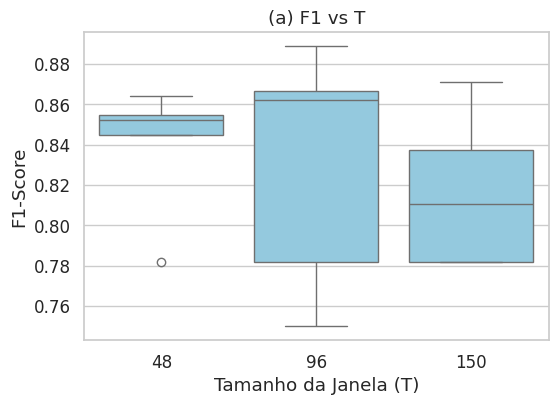

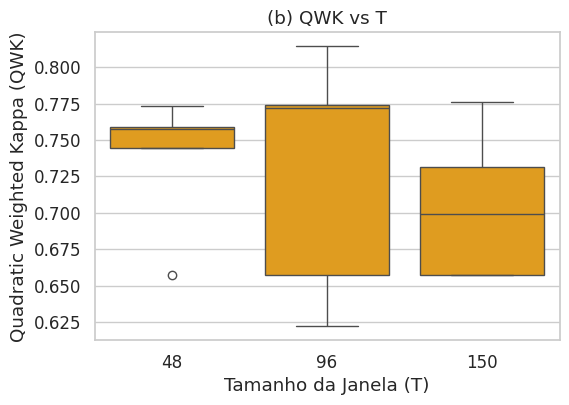

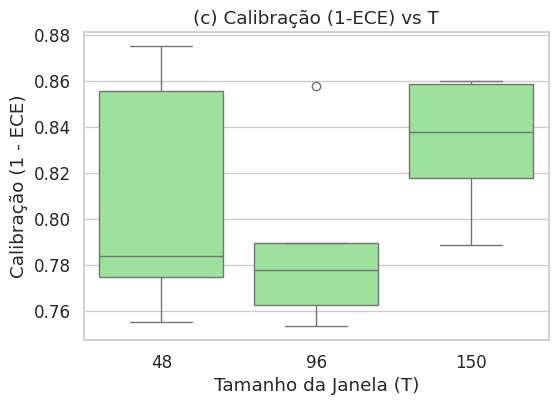

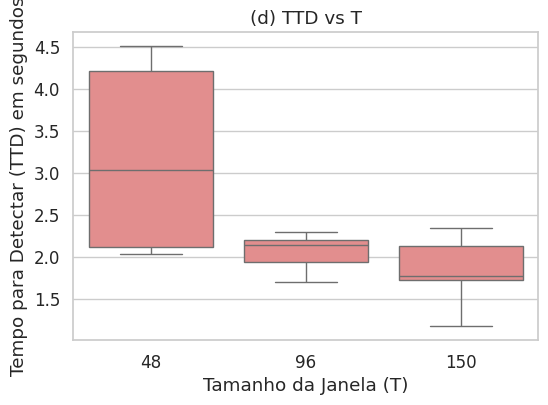


Gráficos de sensibilidade gerados e salvos como .png.
Use estes arquivos .png no seu documento LaTeX.


In [ ]:
# ============================================================
# 6. EXPERIMENTO DE SENSIBILIDADE AO TAMANHO DA JANELA (T)
#    (CORRETO - Para gerar a Figura 6 do artigo)
# ============================================================
print("\n" + "="*50 + "\nINICIANDO EXPERIMENTO DE SENSIBILIDADE (T)\n" + "="*50)

# Imports adicionais para este experimento
from tqdm import tqdm
import seaborn as sns

# --- Configurações do Experimento de Sensibilidade ---
T_VALUES = [48, 96, 150]
N_REPS = 5 # Número de repetições para significância estatística
N_EPISODIOS_PER_RECIPE = 80 # Mantém o mesmo tamanho de dataset do treino principal

resultados_sensibilidade = []

# Salva o TAMANHO_JANELA original para restaurar depois
T_ORIGINAL = TAMANHO_JANELA

for T in T_VALUES:
    print(f"\n===== INICIANDO TESTE DE SENSIBILIDADE PARA T={T} =====")

    # --- ATUALIZAÇÃO CRÍTICA ---
    # Atualiza a variável global TAMANHO_JANELA para que a função
    # tempo_para_detectar_v3 use o FRAME_TIME_SEC correto para este T.
    TAMANHO_JANELA = T

    for rep in range(N_REPS):
        print(f"\n--- Repetição {rep+1}/{N_REPS} para T={T} (Seed={SEED+rep}) ---")
        current_seed = SEED + rep

        # 1. Gerar Dados
        print(f"Gerando dados para T={T}...")
        res = sd.quick_generate(
            window=T, # Usa a variável T do loop
            per_recipe=N_EPISODIOS_PER_RECIPE,
            seed=current_seed,
            recipe_set='base',
            SENSOR_LEVEL=4
        )
        data = np.load(res['npz'])
        X_data, y_ep_data, y_fr_data = data['X'], data['y_episode'], data['y_frame']

        # 2. Dividir Dados (80/20)
        y_ep_binned = (y_ep_data > 0.5).astype(int)
        try:
            X_train, X_test, y_ep_train, y_ep_test, y_fr_train, y_fr_test = train_test_split(
                X_data, y_ep_data, y_fr_data,
                test_size=0.2,
                random_state=current_seed,
                stratify=y_ep_binned
            )
        except ValueError:
            print(f"Aviso: Estratificação falhou para T={T}, Rep={rep}. Usando split simples.")
            X_train, X_test, y_ep_train, y_ep_test, y_fr_train, y_fr_test = train_test_split(
                X_data, y_ep_data, y_fr_data,
                test_size=0.2,
                random_state=current_seed
            )

        # 3. Treinar Modelos (Professor e Aluno)

        # --- Treinar Professor ---
        print("Treinando Professor...")
        # (Precisamos de um professor treinado com o T atual para destilar)
        model_professor = BiLSTM_NaoCausal_Multi(N_VARIAVEIS, HIDDEN_DIM)
        model_professor = treinar_professor_multitask(
            model_professor, X_train, y_fr_train, y_ep_train,
            n_epochs=N_EPOCHS_PROFESSOR # 40 epochs
        )

        # --- Treinar Aluno-KD (o modelo que queremos avaliar) ---
        print("Treinando Aluno-KD (AF-KD)...")
        model_aluno = LSTM_Causal_Multi(N_VARIAVEIS, HIDDEN_DIM)
        model_aluno = treinar_aluno_kd_v33(
            model_aluno, X_train, y_fr_train, y_ep_train, model_professor,
            n_epochs=N_EPOCHS_ALUNO # 50 epochs
        )

        # 4. Avaliar Modelo Aluno-KD
        print("Avaliando Aluno-KD...")
        # Usamos 'avaliar_modelo_multitask' (a 'evaluate_fixed_policy' do seu notebook)
        metrics_aluno = avaliar_modelo_multitask(
            model_aluno, X_test, y_ep_test, y_fr_test, debug_ttd=False
        )

        # 5. Salvar Resultados
        resultados_sensibilidade.append({
            "T": T, "Rep": rep, "Modelo": "Aluno-KD (Fixo)", **metrics_aluno
        })

# Fim do loop de repetição
# Fim do loop de T

# --- Restaura o TAMANHO_JANELA original ---
TAMANHO_JANELA = T_ORIGINAL
print(f"\n===== EXPERIMENTO DE SENSIBILIDADE CONCLUÍDO =====")
print(f"Variável global TAMANHO_JANELA restaurada para {T_ORIGINAL}.")

# ============================================================
# 7. PROCESSAMENTO E PLOTAGEM DOS GRÁFICOS DE SENSIBILIDADE
# ============================================================

df_sensibilidade = pd.DataFrame(resultados_sensibilidade)
df_sensibilidade.to_csv("resultados_sensibilidade_T.csv", index=False)
print("\nResultados da sensibilidade salvos em 'resultados_sensibilidade_T.csv'")

print("\n--- Resultados Agregados (Média) ---")
df_agg = df_sensibilidade.groupby('T')[['F1', 'QWK', 'ECE', 'TTD']].mean()
print(df_agg.to_markdown(floatfmt=".4f"))

# --- Preparação para Plotagem ---
sns.set(style="whitegrid", font_scale=1.1, palette="colorblind")
df_plot = df_sensibilidade.copy()
# Criar coluna de Calibração (1-ECE) como no artigo
df_plot['1-ECE'] = 1.0 - df_plot['ECE']

print("\nGerando gráficos separados para o artigo (Figura 6)...")

# (a) F1 vs T
plt.figure(figsize=(6, 4))
sns.boxplot(x="T", y="F1", data=df_plot, color="skyblue")
plt.title("(a) F1 vs T")
plt.xlabel("Tamanho da Janela (T)")
plt.ylabel("F1-Score")
plt.savefig("f1_vs_t.png", dpi=300, bbox_inches='tight')
plt.show()

# (b) QWK vs T
plt.figure(figsize=(6, 4))
sns.boxplot(x="T", y="QWK", data=df_plot, color="orange")
plt.title("(b) QWK vs T")
plt.xlabel("Tamanho da Janela (T)")
plt.ylabel("Quadratic Weighted Kappa (QWK)")
plt.savefig("qwk_vs_t.png", dpi=300, bbox_inches='tight')
plt.show()

# (c) Calibração (1-ECE) vs T
plt.figure(figsize=(6, 4))
sns.boxplot(x="T", y="1-ECE", data=df_plot, color="lightgreen")
plt.title("(c) Calibração (1-ECE) vs T")
plt.xlabel("Tamanho da Janela (T)")
plt.ylabel("Calibração (1 - ECE)")
plt.savefig("calibracao_vs_t.png", dpi=300, bbox_inches='tight')
plt.show()

# (d) TTD vs T
plt.figure(figsize=(6, 4))
sns.boxplot(x="T", y="TTD", data=df_plot, color="lightcoral")
plt.title("(d) TTD vs T")
plt.xlabel("Tamanho da Janela (T)")
plt.ylabel("Tempo para Detectar (TTD) em segundos")
plt.savefig("ttd_vs_t.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nGráficos de sensibilidade gerados e salvos como .png.")
print("Use estes arquivos .png no seu documento LaTeX.")